# Download dataset with Pytorch



Ссылка на colab: https://colab.research.google.com/drive/1mlK9gf7zlicoohEeLfbo_uTcT0vFGFC6?usp=sharing

## Load the data

In [119]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image

transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define transformation for each image
# transform  = transforms.Compose([
#    transforms.Lambda(lambda x: np.array(x).flatten()), #Stretch image into row [32,32,3] -> [3072]
#])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transform,
                           download=True)

dataset.transform = transforms.Lambda(lambda x: np.array(x).flatten());

Files already downloaded and verified


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])


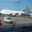

0

In [120]:
train_ds, val_ds, _ = random_split(dataset, [20000, 1000, 29000])
# random_split(dataset, [2000, 100, 47900])
# Hint: Perform debug on smaller subset

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)

# Display one image
for images, class_nums in train_loader:
  print (images.shape, class_nums.shape) # class_nums are tensor!
  display(Image.fromarray(images[0].reshape((32,32,3)).numpy()), class_nums[0].item()) 
  break 

# Implement LinearClassifier class for CIFAR10

In [121]:
import random

class LinearClassifier:
  def __init__(self, labels):
    self.labels = labels
    self.classes_num = len(labels)
    # Generate a random weight matrix of small numbers
    self.W = np.random.randn(3073, self.classes_num) * 0.0001 
    self.batch_size = 256

  
  def train(self, x_train, y_train, learning_rate = 1e-8):
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """
    loss = 0.0
    len = x_train.shape[0]
    indexes = list(range(len))
    random.shuffle(indexes)

    for i in range(0, len, self.batch_size):
        idx = indexes[i:i + self.batch_size]
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        # Bias trick
        x_batch = np.hstack([x_batch, np.ones((x_batch.shape[0], 1))])      # batch 256x3073 
        loss_val, grad = self.loss(x_batch, y_batch)
        loss += loss_val
        self.W -= learning_rate * grad # Weight updating
    

    return loss/x_batch.shape[0]

  def loss(self, x, y): # x and y are batches
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer 
        representing a class number for objects from x
    
    """

    loss = 0.0
    dW = np.zeros(self.W.shape)
    current = x.shape[0]
    for i in range(current): 
      scores = x[i].dot(self.W)               # 1x3073 x 3073x10
      class_score = scores[int(y[i])]
      zero_loss_count = 0
      for j in range(self.classes_num):
          if j == y[i]: 
              continue
          margin = scores[j] - class_score + 1
          if margin > 0:
              zero_loss_count += 1
              loss += margin
              dW[:, j] += x[i]
      dW[:, int(y[i])] -= zero_loss_count * x[i]   
    loss /= current
    dW /= current
    return loss, dW
      
  def predict(self,x):
    x = np.hstack([x, np.ones((x.shape[0], 1))]) 
    scores = x.dot(self.W)                    # (256, 3073) * (3073, 10)
    return np.argmax(scores, axis = 1)


# Train model

## Function for accuracy checking

Don't change this code

In [122]:
from sklearn.metrics import accuracy_score

def validate(model, dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted,index) 
    y_gtrue = np.append(y_gtrue,class_nums.numpy()) 
  return accuracy_score(y_gtrue, y_predicted)  

## Train loop
Let's train our model

In [123]:
# Best: 0.419, time ~ 7 минут
model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 0.224326151007772, Accuracy:0.227
Epoch 1 Loss: 0.195974531715777, Accuracy:0.291
Epoch 2 Loss: 0.18197397257508868, Accuracy:0.318
Epoch 3 Loss: 0.17317501173666272, Accuracy:0.334
Epoch 4 Loss: 0.16615502041020933, Accuracy:0.352
Epoch 5 Loss: 0.1611404387394766, Accuracy:0.368
Epoch 6 Loss: 0.15697845235187588, Accuracy:0.365
Epoch 7 Loss: 0.15302931858113752, Accuracy:0.377
Epoch 8 Loss: 0.1494314274912509, Accuracy:0.387
Epoch 9 Loss: 0.14653940046898178, Accuracy:0.391
Epoch 10 Loss: 0.14384340593964023, Accuracy:0.4
Epoch 11 Loss: 0.14091659449744, Accuracy:0.4
Epoch 12 Loss: 0.13877883928586665, Accuracy:0.4
Epoch 13 Loss: 0.13636695263164605, Accuracy:0.404
Epoch 14 Loss: 0.1342034740727454, Accuracy:0.41
Epoch 15 Loss: 0.1319627419521889, Accuracy:0.412
Epoch 16 Loss: 0.1300063354490379, Accuracy:0.412
Epoch 17 Loss: 0.1279150593092953, Accuracy:0.417
Epoch 18 Loss: 0.1261872729716475, Accuracy:0.419
Epoch 19 Loss: 0.12441478911881278, Accuracy:0.417
Epoch 20 Lo

# Check model on test dataset

You must get accuracy above 0.35


In [124]:
# 0.3531))
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transforms.Lambda(lambda x: np.array(x).flatten()), # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader)
print(f"Accuracy on test:{accuracy}")


Files already downloaded and verified
Accuracy on test:0.3531


# Place for brief conclusion
Feel free to describe troubles here.

Было немного легче, чем в прошлый раз (был экскурс в работу с изображениями, сам линейный классификатор + лайфак с переводом в строку)

Трудность - размерности, пришлось за ними очень внимательно следить

В остальном было вроде бы не сложно)

PS Кажется странным, что кросс-валидация и различные улучшения показали более худший результат. Возможно, это связано с рандомностью деления массива изображений.



# Ideas for extra work

- Implenment CrossEntropyLoss function
- Implement bias trick
- Add regularization to SVM loss
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data


 

Bias trick in LinearClassifier, нормализация в самом начале

In [125]:
# Cross-entropy + regularization

class LinearClassifierBest(LinearClassifier):
    def __init__(self, labels, reg_strength):
      super().__init__(labels)
      self.reg = reg_strength

    def loss(self, x, y):
      samples = x.shape[0]

      # Cross-entropy
      
      scores = x.dot(self.W)                              # 256x10
      max_scores = scores.max(axis = 1, keepdims = True)  # normalize
      scores -= max_scores
      correct = np.array([scores[i][int(y[i])] for i in range(samples)])
      
      # Softmax
      
      loss = - correct.sum() + max_scores.sum() + np.log(np.exp(scores).sum(axis=1)).sum()
      loss /= samples
      loss += self.reg * np.sum(self.W * self.W)
      
      probs = (np.exp(scores) / np.exp(scores).sum(axis=1).reshape(-1, 1))
      dW = np.zeros(x.shape)
      
      # Gradient + regularization
      
      probs[np.arange(samples), y] -= 1
      probs /= samples
      dW = x.T.dot(probs)
      dW += 2 * self.reg * self.W
      return loss, dW

In [132]:
# Best: 0.355, time ~ 6 минут
model = LinearClassifierBest(dataset.classes, 1000)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 0.09554415435366541, Accuracy:0.165
Epoch 1 Loss: 0.09480721553941943, Accuracy:0.208
Epoch 2 Loss: 0.09463187682642801, Accuracy:0.224
Epoch 3 Loss: 0.09472647846638352, Accuracy:0.243
Epoch 4 Loss: 0.09498441623164229, Accuracy:0.256
Epoch 5 Loss: 0.09540485382518878, Accuracy:0.267
Epoch 6 Loss: 0.09600720180504471, Accuracy:0.273
Epoch 7 Loss: 0.09664277211459632, Accuracy:0.277
Epoch 8 Loss: 0.09725016878247929, Accuracy:0.277
Epoch 9 Loss: 0.09783495377770274, Accuracy:0.284
Epoch 10 Loss: 0.09841087794358125, Accuracy:0.295
Epoch 11 Loss: 0.09895182277680326, Accuracy:0.301
Epoch 12 Loss: 0.09945977709203865, Accuracy:0.304
Epoch 13 Loss: 0.09995415431147572, Accuracy:0.31
Epoch 14 Loss: 0.10042930709072335, Accuracy:0.312
Epoch 15 Loss: 0.10087536499834329, Accuracy:0.319
Epoch 16 Loss: 0.10129837625996609, Accuracy:0.321
Epoch 17 Loss: 0.10169958460997446, Accuracy:0.328
Epoch 18 Loss: 0.10207697460820632, Accuracy:0.335
Epoch 19 Loss: 0.10243888886613405, Accura

In [133]:
# 0.3016
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transforms.Lambda(lambda x: np.array(x).flatten()), # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)
accuracy = validate(model, test_loader)
print(f"Accuracy on test:{accuracy}")

Files already downloaded and verified
Accuracy on test:0.3016


In [134]:
# Cross-validation
# 0.418; 1000; 1e-06

learning_rates = [1e-8, 1e-7, 1e-6]
regularization_strengths = [1e3, 1e4, 1e5]
best_val, best_lr, best_reg = 0, 0, 0
for lr in learning_rates:
   for reg in regularization_strengths:
       model = LinearClassifierBest(dataset.classes, reg)
       best_accuracy = 0
       for epoch in range(25):
         for images, class_nums in train_loader:
           loss = model.train(images.numpy(), class_nums.numpy(), lr)
           accuracy = validate(model, val_loader)
         if best_accuracy < accuracy:
           best_accuracy = accuracy
       if best_accuracy > best_val:
           best_val, best_lr, best_reg = best_accuracy, lr, reg
 
print(f'best validation accuracy: {best_val}, reg: {best_reg}, lr:{lr}')

best validation accuracy: 0.418, reg: 1000.0, lr:1e-06


In [137]:
# Best: 0.273, time ~ 5 минут
model = LinearClassifierBest(dataset.classes, 1000)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy(), 1e-6)
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
     best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 0.3499342990004101, Accuracy:0.171
Epoch 1 Loss: 0.24778673259396075, Accuracy:0.165
Epoch 2 Loss: 0.2703957870295536, Accuracy:0.158
Epoch 3 Loss: 0.2934189736529044, Accuracy:0.169
Epoch 4 Loss: 0.4883417526425824, Accuracy:0.273
Epoch 5 Loss: 0.21376860998853142, Accuracy:0.242
Epoch 6 Loss: 0.33844728005316227, Accuracy:0.2
Epoch 7 Loss: 0.22490356774799997, Accuracy:0.25
Epoch 8 Loss: 0.3061649951775279, Accuracy:0.228
Epoch 9 Loss: 0.3509980929742641, Accuracy:0.21
Epoch 10 Loss: 0.3081530925125234, Accuracy:0.168
Epoch 11 Loss: 0.36053291175253477, Accuracy:0.171
Epoch 12 Loss: 0.3475450319340551, Accuracy:0.209
Epoch 13 Loss: 0.3445659408436043, Accuracy:0.178
Epoch 14 Loss: 0.3153483826022762, Accuracy:0.206
Epoch 15 Loss: 0.4496636545423745, Accuracy:0.15
Epoch 16 Loss: 0.2720235819145431, Accuracy:0.214
Epoch 17 Loss: 0.3907281430781828, Accuracy:0.135
Epoch 18 Loss: 0.22755875761034144, Accuracy:0.158
Epoch 19 Loss: 0.35967240867208855, Accuracy:0.174
Epoch 20

In [138]:
# 0.1741
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transforms.Lambda(lambda x: np.array(x).flatten()), # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)
accuracy = validate(model, test_loader)
print(f"Accuracy on test:{accuracy}")

Files already downloaded and verified
Accuracy on test:0.1741
